# Rank Histogram

A rank histogram is a graphical tool for evaluating the reliability of ensemble forecasts,
by plotting the relative frequency of an observation's rank against the sorted values of an ensemble forecast.
If an ensemble of forecasts is probabilistically calibrated, then the observations should
be statistically indistinguishable from random draws from among the ensemble members, and
consequently the rank histogram should be flat.

## Some characteristic shapes of rank histograms

In the first part of this tutorial, we look at some classic types of probabilistic (mis)-calibration
of ensemble forecasts and their characteristic rank histograms.

We consider a process $Y_t$, where $t=0, 1, \ldots, m$, which is generated by independent sampling from the normal distribution
as follows:
$$ Y_t \sim N(\mu_t, 1), \qquad\text{where } \mu_t\sim N(0, 1).$$

We consider six different forecasters who issue ensemble forecasts with 10 ensemble members:

1. **Calibrated (ideal) forecaster**: ensemble members are sampled from $N(\mu_t, 1)$.
2. **Over-prediction forecaster**: ensemble members are sampled from $N(\mu_t + 0.25, 1)$. That is, forecast distribution lies to the right of the true distribution. 
3. **Under-prediction forecaster**: ensemble members are sampled from $N(\mu_t - 0.25, 1)$. That is, forecast distribution lies to the left of the true distribution. 
4. **Over-dispersed forecaster**: ensemble members are sampled from $N(\mu_t, (1.2)^2)$. That is, forecast distribution is wider than the true distribution. 
5. **Under-dispersed forecaster**: ensemble members are sampled from $N(\mu_t, (1/1.2)^2)$. That is, forecast distribution is narrower than the true distribution. 
6. **Calibrated (marginal) forecaster**: ensemble members are sampled from $N(0, 2)$. That is, this forecast distribution well-calibrated but has no knowledge of $\mu_t$. This is equivalent to issuing the climatological forecast for a meteorological process. Forecasts are reliable over the long-run but not accurate.

We'll generate observations and corresponding forecasts and plot their rank histograms.

In [2]:
import numpy as np
import xarray as xr
from scipy.stats import norm
import matplotlib.pyplot as plt
from scores.probability import rank_histogram, crps_for_ensemble


n_time = 100000  # total time steps
n_member = 10  # ensemble size

mu = norm.rvs(loc = 0, scale = 1, size=n_time)  # mu_t

# broadcast mu_t against ensemble size to create ensemble forecasts
mu_broadcast = np.broadcast_to(mu, (n_member, n_time))

# generate the observations
obs = xr.DataArray(
    data=norm.rvs(loc = mu, scale = 1, size=n_time),
    dims=['time'],
    coords={'time': range(n_time)},
    name='obs',
)

# generate the forecasts
fcstA = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast, scale = 1, size=(n_member,n_time)),
    dims=['ens_member', 'time'],
    coords={'ens_member': range(n_member), 'time': range(n_time)},
    name='calibrated (ideal)',
)
fcstB = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast + 0.25, scale = 1, size=(n_member,n_time)),
    dims=['ens_member', 'time'],
    coords={'ens_member': range(n_member), 'time': range(n_time)},
    name='over-prediction',
)
fcstC = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast - 0.25, scale = 1, size=(n_member,n_time)),
    dims=['ens_member', 'time'],
    coords={'ens_member': range(n_member), 'time': range(n_time)},
    name='under-prediction',
)
fcstD = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast, scale = 1.2, size=(n_member,n_time)),
    dims=['ens_member', 'time'],
    coords={'ens_member': range(n_member), 'time': range(n_time)},
    name='over-dispersed',
)
fcstE = xr.DataArray(
    data=norm.rvs(loc = mu_broadcast, scale = 1 / 1.2, size=(n_member,n_time)),
    dims=['ens_member', 'time'],
    coords={'ens_member': range(n_member), 'time': range(n_time)},
    name='under-dispersed',
)
fcstF = xr.DataArray(
    data=norm.rvs(loc = 0, scale = np.sqrt(2), size=(n_member,n_time)),
    dims=['ens_member', 'time'],
    coords={'ens_member': range(n_member), 'time': range(n_time)},
    name='calibrated (marginal)',
)
fcst = xr.merge([fcstA, fcstB, fcstC, fcstD, fcstE, fcstF])

# generate values for the rank histogram
rank_hist = rank_histogram(fcst, obs, "ens_member")
rank_hist

/home/rtaggar/scores/src/scores/probability/rank_hist_impl.py:151: UserWarning: Encountered a NaN in `fcst`. Any forecast case with NaN for one ensemble member will be treated as NaN for all ensemble members.
  warnings.warn(


<xarray.Dataset> Size: 616B
Dimensions:                (rank: 11)
Coordinates:
  * rank                   (rank) int64 88B 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    calibrated (ideal)     (rank) float64 88B 0.09077 0.08925 ... 0.09066
    over-prediction        (rank) float64 88B 0.131 0.116 ... 0.06722 0.0597
    under-prediction       (rank) float64 88B 0.06086 0.06773 ... 0.115 0.1328
    over-dispersed         (rank) float64 88B 0.06318 0.08349 ... 0.06301
    under-dispersed        (rank) float64 88B 0.1243 0.09387 ... 0.09353 0.1241
    calibrated (marginal)  (rank) float64 88B 0.09119 0.09125 ... 0.09054

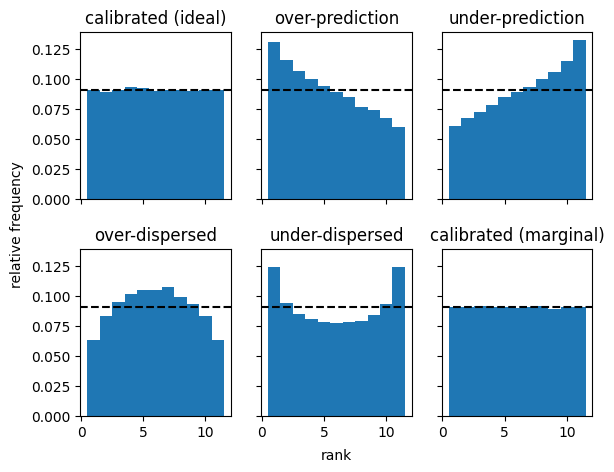

In [3]:
# now plot the rank histogram for each forecaster

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)

for fcst_label, i in zip(list(rank_hist.data_vars), range(6)):
    row, col = int(i / 3), i % 3
    axes[row, col].bar(rank_hist['rank'].values, rank_hist[fcst_label].values, width=1)
    axes[row, col].axhline(y=1/(n_member+1), color='k', linestyle='--')
    axes[row, col].set_title(fcst_label)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.3)
fig.text(0.5, 0.01, 'rank', ha='center')
fig.text(-0.01, 0.5, 'relative frequency', va='center', rotation='vertical')

fig.show()

These illustrate basic characteristic shapes of rank histograms.

- Calibrated forecasters (ideal and marginal) have flat histograms.
- Forecasters with dispersion issues have U-shaped or inverted U-shaped histograms, with too many observations falling either in the centre of the distribution (if over-dispersed) or in the tails of the distribution (if under-dispersed).
- Forecasters with bias (over- or under-prediction) have asymmetric histograms.

Note that a flat histogram doesn't mean that the forecast is more accurate. For example, all four uncalibrated forecasters make better predictions than the calibrated (marginal) forecaster, as measured by the continuous ranked probability score (CRPS), where a lower score indicates a more accurate forecast:

In [4]:
crps_for_ensemble(fcst, obs, "ens_member", method='fair')

<xarray.Dataset> Size: 48B
Dimensions:                ()
Data variables:
    calibrated (ideal)     float64 8B 0.5625
    over-prediction        float64 8B 0.5812
    under-prediction       float64 8B 0.5822
    over-dispersed         float64 8B 0.5694
    under-dispersed        float64 8B 0.5693
    calibrated (marginal)  float64 8B 0.7986

## Rank histograms for discontinuous distributions

The `scores` implementation of the rank histogram also correctly handles the case where the underlying distributions are discontinuous.
With discontinuous distributions, the observation can often match the value of multiple ensemble members,
and its rank is then not unique. In such cases, `scores.probability.rank_histogram` distributes the relative frequency contribution evenly over all possible ranks in the tie.

A classic example of this situation is when forecasting rainfall at a particular location. During a dry spell,
a good forecast will have many ensemble members forecasting 0 millimetres of precipitation, and the corresponding
observation will also often be 0 mm.

We replicate this kind of situtation by taking the previous example and clipping the forecasts and observations to 0 whenever they have negative values.

/home/rtaggar/scores/src/scores/probability/rank_hist_impl.py:151: UserWarning: Encountered a NaN in `fcst`. Any forecast case with NaN for one ensemble member will be treated as NaN for all ensemble members.
  warnings.warn(


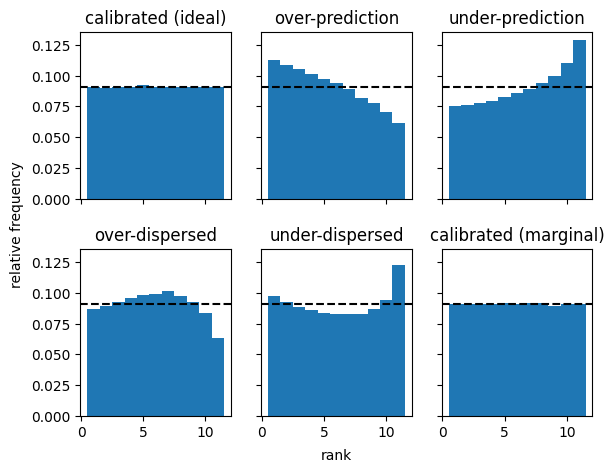

In [5]:
fcst_clipped = fcst.clip(min=0)
obs_clipped = obs.clip(min = 0)
rank_hist_clipped = rank_histogram(fcst_clipped, obs_clipped, "ens_member")

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)

for fcst_label, i in zip(list(rank_hist.data_vars), range(6)):
    row, col = int(i / 3), i % 3
    axes[row, col].bar(rank_hist_clipped['rank'].values, rank_hist_clipped[fcst_label].values, width=1)
    axes[row, col].axhline(y=1/(n_member+1), color='k', linestyle='--')
    axes[row, col].set_title(fcst_label)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.3)
fig.text(0.5, 0.01, 'rank', ha='center')
fig.text(-0.01, 0.5, 'relative frequency', va='center', rotation='vertical')

fig.show()

As before, we see that the calibrated forecast systems have flat histograms, even though in many forecast cases the rank of the observation is not unique.

## Flat rank histograms do not imply that a forecast system is well-calibrated.

Hamill (2001) showed that a conditionally mis-calibrated forecast system can have flat histograms. That is, while a calibrated system has an expected flat rank histogram, a flat rank histogram does not imply that the forecast system is well-calibrated. The following is inspired by Hamill's example and also illustrates how weighting works.





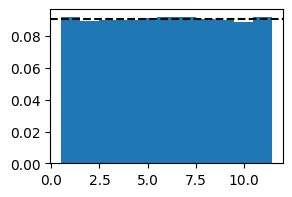

In [6]:
# generate observations for three locations, all from the standard normal distribution N(0,1)
obs = xr.DataArray(
    data=norm.rvs(loc=0, scale=1, size=(3, n_time)),
    dims=['location', 'time'],
    coords={'location': ['city', 'hill', 'valley'], 'time': range(n_time)}
)

# forecasts for the city are under-predictions N(-0.5, 1)
fcst_city = xr.DataArray(
    data=norm.rvs(loc=-0.5, scale=1, size=(n_time, n_member, 1)),
    dims=['time', 'ens_member', 'location'],
    coords={'time': range(n_time), 'ens_member': range(n_member), 'location': ['city']}
)
# forecasts for the hill are over-predictions N(0.5, 1))
fcst_hill = xr.DataArray(
    data=norm.rvs(loc=0.5, scale=1, size=(n_time, n_member, 1)),
    dims=['time', 'ens_member', 'location'],
    coords={'time': range(n_time), 'ens_member': range(n_member), 'location': ['hill']}
)
# forecasts for the valley are over-dispersed N(0, 1.3**2)
fcst_valley = xr.DataArray(
    data=norm.rvs(loc=0, scale=1.3, size=(n_time, n_member, 1)),
    dims=['time', 'ens_member', 'location'],
    coords={'time': range(n_time), 'ens_member': range(n_member), 'location': ['valley']}
)
# combine forecasts into one data array
fcst = xr.concat([fcst_city, fcst_hill, fcst_valley], 'location')

# include some weights - we'll start with equal weighting on city, hill and valley forecasts
weights = xr.DataArray(data=[1, 1, 1], dims=['location'], coords={'location': ['city', 'hill', 'valley']})
rank_hist_weighted = rank_histogram(fcst, obs, "ens_member", reduce_dims='all', weights=weights)

# we now plot the rank histogram for all forecats combined
fig, axes = plt.subplots(1, 1, figsize=(3, 2))
plt.bar(rank_hist_weighted['rank'].values, rank_hist_weighted.values, width=1)
plt.axhline(y=1/(n_member+1), color='k', linestyle='--')
fig.show()

# We get an almost flat histogram

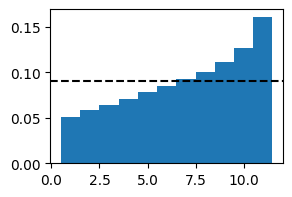

In [7]:
# However, we can expose conditional miscalibration by putting a higher weight on some locations and a lower weight on others.

# For example, here is the rank histogram with a high weight on city forecasts:
weights = xr.DataArray(data=[10, 1, 1], dims=['location'], coords={'location': ['city', 'hill', 'valley']})
rank_hist_weighted = rank_histogram(fcst, obs, "ens_member", reduce_dims='all', weights=weights)

fig, axes = plt.subplots(1, 1, figsize=(3, 2))
plt.bar(rank_hist_weighted['rank'].values, rank_hist_weighted.values, width=1)
plt.axhline(y=1/(n_member+1), color='k', linestyle='--')
fig.show()

# the histogram shows a classic under-prediction signature

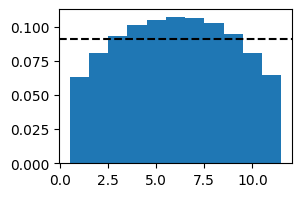

In [8]:
# repeat, but with a high weight on valley forecasts
weights = xr.DataArray(data=[1, 1, 10], dims=['location'], coords={'location': ['city', 'hill', 'valley']})
rank_hist_weighted = rank_histogram(fcst, obs, "ens_member", reduce_dims='all', weights=weights)

fig, axes = plt.subplots(1, 1, figsize=(3, 2))
plt.bar(rank_hist_weighted['rank'].values, rank_hist_weighted.values, width=1)
plt.axhline(y=1/(n_member+1), color='k', linestyle='--')
fig.show()

# the histogram shows a classic over-dispersed signature

## Relationship to the Probability Integral Transform (PIT)

The rank histogram is very closely related to the probabily integral transform (PIT) and
PIT histograms. 

The `scores.probability.Pit` implementation of PIT in `scores` has several advantages over
`scores.probability.rank_histogram`, as it includes:

- objective measures of dispersion and bias
- an object measure of deviation from 'calibration'
- values for PIT-uniform probability plots, which is another visual tool for diagnosing mis-calibration
- forecast cases where there are `NaN` values among some of the ensemble members by treating such cases as a smaller ensemble
    (whereas `rank_histogram` ignores all such cases, since the number of ranks cannot vary by forecast case)

However, one possible downside of the `scores.probability.Pit` implementation is that it treats an ensemble of forecasts
as an empirical cumulative distribution function (ECDF). An ensemble may be well-calibrated, but when interpreted as
an ECDF it may not be. The rank histogram avoids this problem.

See the [tutorial on PIT](./PIT.ipynb) for further information.

## Things to try next

Can you start with an over-dispersed forecast at one location and an under-dispersed forecast at another location
and, by choosing appropriate weightings, produce a combined ranked histogram that is flat?

## References

Hamill, T. M. (2001). Interpretation of rank histograms for verifying ensemble forecasts. Monthly Weather Review, 129(3), 550-560.
[https://doi.org/10.1175/1520-0493(2001)129<0550:IORHFV>2.0.CO;2](https://doi.org/10.1175/1520-0493(2001)129<0550:IORHFV>2.0.CO;2)